# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find optimal location for new **shopping mall ( size > 20.000 $m^2$ )**. Specifically,this report will be targeted to stakeholders interested in opening a shopping mall in **Vilnius**, Lithuania. 

The questions we need the answers for are:
* Which Vilnius borough make the most sense to build a new mall in?
* How many shops our new mall would have?


Since there are a lot of smaller shopping centers and fewer big ones, we will try to find the **best borough/boroughs**  where are no big shopping malls and smaller concentrations of small to mid size shopping centers.

We will use our data science powers to generate a few, most promising neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.


## Data <a name="data"></a>


Based on definition of our problem, questions (and found answers) that will influence our decission are:
* is there another big shopping mall in a borough?
* if not, how many smaller shops are in a borough we might be interested in
* if there are several locations, what is the population for the upcoming shopping mall **(pop/size)**? 


Following data sources will be needed to extract/generate the required information:
* number of malls,shop centers and their type and location in every borough will be obtained using Wikipedia and other online resources
* coordinate of Vilnius boroughs  will be obtained using **Geocodind and OpenStreetMaps** 
* Other necessary data will be taken from Wikipedia and all other avialable sources online (population,mall size, ect.)

### Let import all necessary libraries for our project

In [1]:
import pandas as pd 
import folium
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup
import requests
from pandas.io.json import json_normalize
import numpy as np 
import json
from shapely.geometry import shape, Point
from urllib.request import urlopen
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline

##### Our target is Vilnius. Lets get coordinates for this city and some necessary functions/methods

In [2]:
#getting coordinates of Vilnius city 
address = 'Vilnius, LT'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of VIlnius City are {}, {}.'.format(latitude, longitude))


The geographical coordinate of VIlnius City are 54.6870458, 25.2829111.


In [3]:
###lets create function to get coordinates of the street name or the place name 

def get_coordinates(name_or_address):
    geolocator = Nominatim(user_agent="first")
    location = geolocator.geocode(name_or_address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

In [4]:
###function to get boroughs name of Vilnius by given coordinates
### We get geojson file from Vilnius open data protal: 

def get_borough(longitude,latitude):
    with urlopen('http://gis-vplanas.opendata.arcgis.com/datasets/6d5088b44dba4643a6611455d5352268_1.geojson') as file:
        source = file.read()
        data =json.loads(source)
        point = Point(longitude,latitude)
        for n in data['features']:
            borough_n = n['properties']['SENIUNIJA']
            #print(borough_n)
            coord= n['geometry']
            polygon = shape(coord)
            if polygon.contains(point):
                return borough_n

# Now we scrape the data for our new datasets:
* First: we get main/biggest shopping mall list
* Then we acquire data for smaller shop/chain list
* Getting all necessary data of all boroughs of Vilnius
* Later, using Foursquare API we get more shops in different size from different domains


#### Getting main shopping mall list

In [5]:
#### Creating main shopping mall list #####
### Data is acquired from Wikipedia #####


#Creating pandas dataframe :
# Getting main shopping mall data
columnn_names = ['Mall_name', 'City','Year_built','Size_$m^2$','Number_of_shops']
# our new dataframe
mall = pd.DataFrame(columns= columnn_names)
web_page = requests.get('https://en.wikipedia.org/wiki/List_of_shopping_malls_in_Lithuania').text
soup = BeautifulSoup(web_page, 'lxml')
#Taking out specific range (<tr> wraps tables' elements)
table = soup.find_all('tr')
for table in table[1:]:
    a = table.text
    a = a.strip()
    a=a.split('\n')
    #getting rid of empty elements
    a = list(filter(None, a))
    a.pop(0)
    del a[5:7]
    # cleaning the 'size' column
    a[1] = a[1].strip()
    a[2]= a[2][0:4]
    a[3]= a[3][0:7]
    a[3] = a[3].replace(',','.')
    a[4] = a[4].replace('+','')   
    #creat ng our dataset
    mall = mall.append({'Mall_name':a[0], 'City': a[1], 'Year_built': a[2], 'Size_$m^2$':a[3], 'Number_of_shops':a[4]},
                       ignore_index = True)
    
#now let see all shopping malls only in Vilnius
mall = mall[mall['City'] == 'Vilnius'].reset_index(drop = True)
# as we see Gariunai market is a huge one but it doesn't fit in our terms because it is open air market and we remove it
mall.drop([1], axis = 0, inplace= True)
mall = mall.reset_index(drop = True)
mall.iloc[[1,4],4] = 'NaN'
#changing uknown shops with the averages
mall['Number_of_shops']= mall['Number_of_shops'].astype('float')
mean = mall['Number_of_shops'].mean()
mean = int(mean)
mall['Number_of_shops'].replace(np.NaN, mean, inplace = True)

# lets add new columns to mall dataframe : latitude and longitude
mall = mall.assign(latitude = np.nan, longitude = np.nan)
#change the name of akropolis
mall.iat[0, 0] = 'PLC Akropolis'

# lets add coordinates

indx = mall.index.tolist()
for n in indx:
    try:
        name = mall['Mall_name'][n] + ', Vilnius'
        gm = get_coordinates(name)
        latitude = gm[0]
        longitude = gm[1]
        mall.at[n,'latitude'] = latitude
        mall.at[n, 'longitude'] = longitude
    except:
        print('We have a problem with:', name)
mall

# we find and add manually fro Ogmios miestas 
mall.at[5,'latitude'] = 54.7132
mall.at[5,'longitude'] = 25.2987
mall['Number_of_shops']= mall['Number_of_shops'].astype('int')
mall.head()
### Adding Boroughs
# for our main malls: we need to  add only boroughs
mall = mall.assign(Borough = np.nan)
mall['Borough']= mall['Borough'].astype('object')
for n in indx:
    l_1 = mall.at[n, 'longitude']
    l_2 = mall.at[n, 'latitude']
    mall.at[n, 'Borough'] = get_borough(l_1,l_2)

    
mall


We have a problem with: Ogmios miestas, Vilnius


,Mall_name,City,Year_built,Size_$m^2$,Number_of_shops,latitude,longitude,Borough
0,PLC Akropolis,Vilnius,2002,109.775,240,54.710615,25.263335,Šeškinė
1,Akropolis 2,Vilnius,2021,70.000,95,54.673795,25.236609,Vilkpėdė
2,Panorama,Vilnius,2005,65.000,180,54.672107,25.284008,Senamiestis
3,PC Ozas,Vilnius,2009,62.000,170,54.713731,25.272364,Verkiai
4,PC Pilaitė,Vilnius,2019,60.000,95,54.709934,25.187405,Pilaitė
5,Ogmios miestas,Vilnius,2010,43.000,100,54.713200,25.298700,Žirmūnai
6,Nordika,Vilnius,2015,38.000,50,54.652039,25.276879,Naujininkai
7,PC Mada,Vilnius,2003,34.000,100,54.708618,25.228375,Viršuliškės
8,Banginis,Vilnius,2004,28.000,10,54.710225,25.302089,Žirmūnai
9,BIG Vilnius,Vilnius,2006,28.000,70,54.740519,25.228510,Fabijoniškės


#### Getting list of the smaller chains/shops in Vilnius

In [6]:
### Getting the info from info portal : https://www.1551.lt/prekybos-centrai/vilnius #####



columnn_names = ['Shopping_center_name','Address']
# our new dataframe
major_shops = pd.DataFrame(columns= columnn_names)

#for number in range(1,4):
url ='https://www.1551.lt/prekybos-centrai/vilnius/'
for round in range (1,7):
    if round == 1:
        web_url = url
    else:
        web_url = url+'?p='+ str((round))
    
    web_page = requests.get(web_url).text
    soup = BeautifulSoup(web_page, 'lxml')
    #Taking out specific range (<tr> wraps tables' elements)
    table = soup.find_all('div', class_ = "tm-result uk-panel uk-panel-box")
    table_1 = soup.find_all('span', class_ = 'uk-margin-right')
    for s, v in zip(table,table_1):
        m = s.h3.a.text
        v = v.text
        v = v.split(',')
        vv = v[0]
        vv = vv.split('/')
        major_shops= major_shops.append({'Shopping_center_name': m ,'Address': vv[0] },ignore_index = True)

####adding new columns and convert to coordinates
major_shops = major_shops.assign(latitude = np.nan, longitude = np.nan)
#major_shops.dtypes
### after finding incorrect one
major_shops.at[19, 'Address'] = 'Ukmergės g. 315'
idx = major_shops.index.tolist()

for n in idx:
    try:
        address = major_shops.at[n,'Address']
        #print(address)
        cord = get_coordinates(address)
        #print(cord , cord[0], cord[1])
        major_shops.at[n,'latitude']= cord[0]
        major_shops.at[n,'longitude']= cord[1]
        print('Adding address:', address)
    except:
        add1 = []
        add1.insert(0, address) 
        print('We have a problem with:', address)
        
        
        #major_shops =major_shops.append({'latitude': l_3, 'longitude': l_4}, ignore_index= True)

#getting info bad formatted addresses (if there are any)    

#for ad in add1:
    #for n in idx:
        #s = major_shops.at[n, 'Address']
        #if s == ad:
            #print('\n','\033[1m' + 'Address to look up for:', ad ,'\033[1m' 'and its\'s index number is:', n)


major_shops

Adding address: Upės g. 9
Adding address: Ozo g. 25
Adding address: Konstitucijos pr. 7 A
Adding address: Vikingų g. 3
Adding address: Ozo g. 25
Adding address: Savanorių pr. 247
Adding address: Justiniškių g. 91
Adding address: Lentvario g. 33
Adding address: Savanorių pr. 16
Adding address: Viršuliškių skg. 34-1
Adding address: Šiaurės g. 37
Adding address: Ateities g. 91
Adding address: Laisvės pr. 125
Adding address: Viršuliškių g. 40
Adding address: Žirmūnų g. 55-9
Adding address: Gedimino pr. 9
Adding address: Visorių g. 8
Adding address: Verkių g. 29
Adding address: Ozo g. 18
Adding address: Ukmergės g. 315
Adding address: Vikingų g. 1
Adding address: Verkių g. 29
Adding address: J. Basanavičiaus g. 11-1
Adding address: Konstitucijos pr. 7
Adding address: Kirtimų g. 47
Adding address: Viršuliškių g. 42
Adding address: Savanorių pr. 174
Adding address: Gedimino pr. 2
Adding address: Vikingų g. 3
Adding address: Jogailos g. 9
Adding address: Ozo g. 18
Adding address: Savanorių pr.

,Shopping_center_name,Address,latitude,longitude
0,"VILNIAUS CENTRINĖ UNIVERSALINĖ PARDUOTUVĖ, AB",Upės g. 9,54.694144,25.275639
1,"AKROPOLIS, UAB",Ozo g. 25,54.709939,25.263088
2,"EUROPA - mados ir stiliaus centras, UAB BH Europa",Konstitucijos pr. 7 A,54.697991,25.269181
3,"NORDIKA, UAB",Vikingų g. 3,54.653349,25.276705
4,"VILNIAUS PREKYBA, UAB",Ozo g. 25,54.709939,25.263088
5,"MAXIMA LT, UAB",Savanorių pr. 247,54.642711,25.178981
6,"JUSTINIŠKĖS, UAB",Justiniškių g. 91,54.717892,25.222722
7,"PALINK, UAB",Lentvario g. 33,54.649340,25.121437
8,"RIMI LIETUVA, UAB",Savanorių pr. 16,54.642711,25.178981
9,"LIDL LIETUVA, UAB",Viršuliškių skg. 34-1,54.702679,25.213738


#### Getting all necessary information of Vilnius' boroughs:

In [7]:
####now lets get info about population and overall size oof the bouroughs:###
#Creating pandas dataframe :
columnn_names = ['Borough_name', 'Size_$km^2$','Number_of_people']
# our new dataframe
boroughs = pd.DataFrame(columns= columnn_names)
boroughs
web_page = requests.get('https://lt.wikipedia.org/wiki/Vilniaus_miesto_savivaldyb%C4%97').text
soup = BeautifulSoup(web_page, 'lxml')
tabl3 = soup.find_all('table', class_ = 'wikitable')
for tag in tabl3:
    sa = tag.find_all('tbody')
    for k in sa:
        dz = k.find_all('tr')
        for u in dz[1:]:
            u = u.text
            u =u.strip()
            u=u.split('\n')
            u = list(filter(None, u))
            u.pop(0)
            u[1] = u[1].replace('\xa0km²', '')
            u[1] = u[1].replace(',', '.')
            boroughs = boroughs.append({'Borough_name':u[0], 'Size_$km^2$': u[1], 'Number_of_people': u[2]},
                       ignore_index = True)
            
boroughs['Size_$km^2$']= boroughs['Size_$km^2$'].astype(float)
boroughs['Number_of_people'] = boroughs['Number_of_people'].astype(int)
# lets add new column with ppl/km^2
boroughs = boroughs.assign(density = np.nan)
indxl = boroughs.index.tolist()
for n in indxl:
    boroughs.at[n, 'density'] =  boroughs['Number_of_people'][n]/boroughs['Size_$km^2$'][n]
boroughs['density']=boroughs['density'].astype(int)
boroughs.rename(columns={'density': 'density ppl/$km^2$'}, inplace= True)

#### UPDATING BOROUGHS TABLE THAT IT WOULD MATCH JSON FILE

with urlopen('http://gis-vplanas.opendata.arcgis.com/datasets/6d5088b44dba4643a6611455d5352268_1.geojson') as file:
    source = file.read()
    data =json.loads(source)
    #print(json.dumps(data, indent = 2))
    for n in data['features']:
        for v in indxl:
            a = n['properties']['SENIUNIJA']
            if boroughs.at[v,'Borough_name'][0:5] == a[0:5]:
                    boroughs.at[v,'Borough_name']= a


### we see we have problem with : Rasu seniunija. It should be: Rasos
boroughs.at[20, 'Borough_name'] = 'Rasos'

boroughs.head(22)


,Borough_name,Size_$km^2$,Number_of_people,density ppl/$km^2$
0,Verkiai,55.65,30900,555
1,Antakalnis,77.20,39700,514
2,Pašilaičiai,8.20,25700,3134
3,Fabijoniškės,4.10,36600,8926
4,Pilaitė,13.80,16000,1159
5,Justiniškės,2.98,30958,10388
6,Viršuliškės,2.50,16300,6520
7,Šeškinė,4.40,36600,8318
8,Šnipiškės,3.12,19321,6192
9,Žirmūnai,8.50,47400,5576


In [8]:
#### lets sort based on density
boroughs.sort_values(by = ['density ppl/$km^2$'], ascending= False).reset_index(drop= True)

,Borough_name,Size_$km^2$,Number_of_people,density ppl/$km^2$
0,Justiniškės,2.98,30958,10388
1,Fabijoniškės,4.10,36600,8926
2,Šeškinė,4.40,36600,8318
3,Karoliniškės,4.00,31200,7800
4,Viršuliškės,2.50,16300,6520
5,Šnipiškės,3.12,19321,6192
6,Naujamiestis,4.80,27900,5812
7,Žirmūnai,8.50,47400,5576
8,Senamiestis,4.50,21000,4666
9,Žvėrynas,2.70,12200,4518


### Getting extra list of shops from Foursquare API

In [9]:
#####Getting extra shops and convience stores aroundthe center!
CLIENT_ID = 'W5ZRBFTANSKJEO1AITF3PYBIIIRPFJTSWXZWHTCQQCTAKV2Y' # your Foursquare ID
CLIENT_SECRET = 'I3ZV5SDUXR0VSQWXEF1WUZXDKAIN3P3NXLVSJTBYQLNJB5EC' # your Foursquare Secret
VERSION = '20180604'

###let's assign all categoryId to list of the shops = potencial rivals
Id = ['4d4b7105d754a06378d81259','5267e446e4b0ec79466e48c4','52f2ab2ebcbc57f1066b8b32','52f2ab2ebcbc57f1066b8b42',
      '4bf58dd8d48988d115951735','4bf58dd8d48988d114951735','4bf58dd8d48988d117951735',
             '4bf58dd8d48988d103951735','4d954b0ea243a5684a65b473','4bf58dd8d48988d10c951735','4bf58dd8d48988d1f6941735',
             '52dea92d3cf9994f4e043dbb','5745c2e4498e11e7bccabdbd', '4bf58dd8d48988d1f9941735','52f2ab2ebcbc57f1066b8b1c',
             '4bf58dd8d48988d1f8941735','4bf58dd8d48988d112951735','50be8ee891d4fa8dcc7199a7']
catalog = {}
for categoryId in Id:
    radius = 20000
    LIMIT = 100
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
    results = requests.get(url).json()
    venues = results['response']['venues']
    
    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    #dataframe.head(10)
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]
    
    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']
            
        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']
    
    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
    
    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    
    #dataframe_filtered.head(10)
    #dataframe_filtered[['name','categories','address','lat','lng']].head(10)
    catalog[categoryId] = dataframe_filtered

##### Now we will compare all dataframes and add them to one , plus dropping the same 
## first let's change dict names by numbers for easy 
for n, nr in zip(Id, range(1,len(Id)+1)):
                 ch = catalog[n]
                 del catalog[n]
                 catalog[nr]= ch
##Create main Table and start to merge tables one by one

for cat_nr in range(2, len(Id)+1):
    table_four = catalog[1][['name','categories','address','lat','lng']]
    temp_table = catalog[cat_nr][['name','categories','address','lat','lng']]
    table_four = pd.concat([table_four, temp_table], sort= True)
    table_four.drop_duplicates(subset = (['name','lat','lng']), keep = 'first', inplace = True)
    table_four.reset_index(drop = True)

##lets remove duplicates 

ixx = table_four.index.tolist()
for nr in ixx:
    try:
        
        x_add = table_four.at[nr,'address'].item(0)
    
        for x in idx:
            y_add = major_shops.at[x,'Address']
        
            if x_add == y_add:
                table_four.drop(table_four.index[nr], inplace= True)
    except:
        pass

table_four = table_four.reset_index(drop = True)


table_four.head(20)

,address,categories,lat,lng,name
0,Vikingų g. 1,Furniture / Home Store,54.651493,25.279976,IKEA
1,Vikingų g. 3,Supermarket,54.653749,25.277831,Rimi Hypermarket
2,Žalgirio g. 105,Grocery Store,54.704198,25.283074,MAXIMA XX
3,Kalvarijų g. 180,Grocery Store,54.713880,25.286328,Lidl
4,Sausio 13-osios g. 2,Supermarket,54.692683,25.220987,Maxima XX
5,Pilaitės pr. 31,Supermarket,54.709392,25.188781,Maxima XX
6,Pylimo g. 21,Convenience Store,54.678799,25.278522,IKI Express Pylimo
7,Saltoniškių g. 9,Supermarket,54.700385,25.257695,RIMI Hypermarket
8,Ukmergės g. 369,Grocery Store,54.739990,25.228445,MAXIMA XX
9,Vikingų g. 3,Hardware Store,54.651624,25.277995,Senukai


# Visualization:
### Lets create a map and show all our major shopping malls,  shop-chains, and other shops based on density of population of different boroughs:

In [10]:
####getting coordinates of Vilnius city and then getting the map####

geo = r'http://gis-vplanas.opendata.arcgis.com/datasets/6d5088b44dba4643a6611455d5352268_1.geojson'
address = 'Vilnius, LT'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of the center of Vilnius City are {}, {}.'.format(latitude, longitude))
map_vilnius = folium.Map(location=[latitude, longitude], zoom_start=10.5)


#lets show all shops on the map
folium.Choropleth(
    geo_data=geo,
    name='choropleth',
    data=boroughs,
    columns=['Borough_name', 'density ppl/$km^2$'],
    key_on='feature.properties.SENIUNIJA',
    fill_color='YlGn',
    fill_opacity=0.5,
    line_opacity=0.5,
    legend_name='Density '
).add_to(map_vilnius)
folium.LayerControl().add_to(map_vilnius)

indx = mall.index.tolist()
for n in indx:
    nm = mall['Mall_name'][n]
    lat = mall.at[n,'latitude']
    lng = mall.at[n, 'longitude']
    folium.Marker(
        location=[lat, lng],
        popup= nm,
        icon=folium.Icon(icon='info-sign', color ='red')
    ).add_to(map_vilnius)

for n in idx:
    nm = major_shops['Shopping_center_name'][n]
    lat = major_shops.at[n,'latitude']
    lng = major_shops.at[n, 'longitude']
    folium.Circle(
        location=[lat, lng],
        popup= nm,
        radius= 20,
        color = 'crimson'
    ).add_to(map_vilnius)

    
    
ixxx = table_four.index.tolist()
for n in ixxx:
    nm = table_four['name'][n]
    lat = table_four.at[n,'lat'].item(0)
    lng = table_four.at[n, 'lng'].item(0)
    folium.Circle(
        location=[lat, lng],
        popup= nm,
        radius= 20,
        color = 'crimson'
    ).add_to(map_vilnius)

    
map_vilnius

The geographical coordinate of the center of Vilnius City are 54.6870458, 25.2829111.


# Methodology

In this project we will direct our efforts on detecting boroughs of Vilnius that would make most sense to build new big shopping mall. Especially we are looking for a place where there is no big shop mall presence and concentration of smaller shops at least average and density of population as higher. 

In first step we have collected the required data: all current data of big malls, list of smaller chains and some different purpose shops from Foursquare API. Then we showed up everything on the map.

Second step in our analysis will be to take the boroughs which are best suitable for us : First, the ones which don't have big shop mall at all, then the ones with lower number of shop overall. Then we will compare available available lands/objects  currently for sale and will find the best choice.

In third and final step we will focus on most promising areas and in the ones using Logistic regression to decide what size and how many shops will contain our new shopping mall.

## Checking best possible locations based of already mentioned criterias :

In [11]:
#### Now lets expand our Boorough's table and add two new columns with Big Malls and Shops #### 

boroughs = boroughs.assign(mall = 0, shops = 0)
boroughs.head()

,Borough_name,Size_$km^2$,Number_of_people,density ppl/$km^2$,mall,shops
0,Verkiai,55.65,30900,555,0,0
1,Antakalnis,77.20,39700,514,0,0
2,Pašilaičiai,8.20,25700,3134,0,0
3,Fabijoniškės,4.10,36600,8926,0,0
4,Pilaitė,13.80,16000,1159,0,0


In [12]:
####now lets see how many malls in all boroughs we do have#####


for n in indx:
    x_cord = mall.at[n, 'latitude']
    y_cord = mall.at[n, 'longitude']
    br = get_borough(y_cord,x_cord)
    for x in indxl:
        n_cord = boroughs.at[x, 'Borough_name']
        
        if n_cord == br :
            s = boroughs.at[x,'mall']
            s = s + 1 
            boroughs.at[x,'mall'] = s 
            print('The borough', br, 'has =',s, 'shopping mall')
        else:
            pass
            
boroughs   

The borough Šeškinė has = 1 shopping mall
The borough Vilkpėdė has = 1 shopping mall
The borough Senamiestis has = 1 shopping mall
The borough Verkiai has = 1 shopping mall
The borough Pilaitė has = 1 shopping mall
The borough Žirmūnai has = 1 shopping mall
The borough Naujininkai has = 1 shopping mall
The borough Viršuliškės has = 1 shopping mall
The borough Žirmūnai has = 2 shopping mall
The borough Fabijoniškės has = 1 shopping mall
The borough Šnipiškės has = 1 shopping mall
The borough Šnipiškės has = 2 shopping mall
The borough Žirmūnai has = 3 shopping mall
The borough Senamiestis has = 2 shopping mall
The borough Pašilaičiai has = 1 shopping mall
The borough Fabijoniškės has = 2 shopping mall


,Borough_name,Size_$km^2$,Number_of_people,density ppl/$km^2$,mall,shops
0,Verkiai,55.65,30900,555,1,0
1,Antakalnis,77.20,39700,514,0,0
2,Pašilaičiai,8.20,25700,3134,1,0
3,Fabijoniškės,4.10,36600,8926,2,0
4,Pilaitė,13.80,16000,1159,1,0
5,Justiniškės,2.98,30958,10388,0,0
6,Viršuliškės,2.50,16300,6520,1,0
7,Šeškinė,4.40,36600,8318,1,0
8,Šnipiškės,3.12,19321,6192,2,0
9,Žirmūnai,8.50,47400,5576,3,0


In [13]:
### Now let's do the same with overall number of shops in those boroughs###

In [14]:
##from major_shop dataframe##
for n in idx:
    x_cord = major_shops.at[n, 'latitude']
    y_cord = major_shops.at[n, 'longitude']
    br = get_borough(y_cord,x_cord)
    for x in indxl:
        n_cord = boroughs.at[x, 'Borough_name']
        
        if n_cord == br :
            s = boroughs.at[x,'shops']
            s = s + 1 
            boroughs.at[x,'shops'] = s 
            print('The borough', br, 'has =',s, 'overall shops')
        else:
            pass
        
##Foursquare##          
for n in ixx:
    try:
        
        x_cord = table_four.at[n, 'lat']
        y_cord = table_four.at[n, 'lng']
        br = get_borough(y_cord,x_cord)
        for x in indxl:
            n_cord = boroughs.at[x, 'Borough_name']
            
            if n_cord == br :
                s = boroughs.at[x,'shops']
                s = s + 1 
                boroughs.at[x,'shops'] = s 
                print('The borough', br, 'has =',s, 'overall shops')
            else:
                pass
    except:
        pass




The borough Šnipiškės has = 1 overall shops
The borough Šeškinė has = 1 overall shops
The borough Šnipiškės has = 2 overall shops
The borough Naujininkai has = 1 overall shops
The borough Šeškinė has = 2 overall shops
The borough Paneriai has = 1 overall shops
The borough Justiniškės has = 1 overall shops
The borough Paneriai has = 2 overall shops
The borough Paneriai has = 3 overall shops
The borough Viršuliškės has = 1 overall shops
The borough Naujoji  Vilnia has = 1 overall shops
The borough Fabijoniškės has = 1 overall shops
The borough Pašilaičiai has = 1 overall shops
The borough Viršuliškės has = 2 overall shops
The borough Žirmūnai has = 1 overall shops
The borough Senamiestis has = 1 overall shops
The borough Fabijoniškės has = 2 overall shops
The borough Žirmūnai has = 2 overall shops
The borough Verkiai has = 1 overall shops
The borough Pašilaičiai has = 2 overall shops
The borough Naujininkai has = 2 overall shops
The borough Žirmūnai has = 3 overall shops
The borough Sena

The borough Naujamiestis has = 18 overall shops
The borough Naujamiestis has = 19 overall shops
The borough Senamiestis has = 18 overall shops
The borough Fabijoniškės has = 13 overall shops
The borough Šnipiškės has = 14 overall shops
The borough Antakalnis has = 11 overall shops
The borough Naujoji  Vilnia has = 4 overall shops
The borough Naujamiestis has = 20 overall shops
The borough Šeškinė has = 11 overall shops
The borough Žirmūnai has = 19 overall shops
The borough Senamiestis has = 19 overall shops
The borough Antakalnis has = 12 overall shops
The borough Žirmūnai has = 20 overall shops


In [15]:
boroughs.head()


,Borough_name,Size_$km^2$,Number_of_people,density ppl/$km^2$,mall,shops
0,Verkiai,55.65,30900,555,1,13
1,Antakalnis,77.20,39700,514,0,12
2,Pašilaičiai,8.20,25700,3134,1,9
3,Fabijoniškės,4.10,36600,8926,2,13
4,Pilaitė,13.80,16000,1159,1,8


In [16]:
## sorting 
br_new_table = boroughs[['Borough_name','density ppl/$km^2$', 'mall','shops']]
br_new_table = br_new_table.sort_values(by = 'mall', ascending = False)


In [17]:
## now getting the boroughs which don't have malls in
br_new_table = br_new_table[br_new_table['mall'] == 0].reset_index(drop = True)


In [18]:
br_new_table

,Borough_name,density ppl/$km^2$,mall,shops
0,Paneriai,104,0,9
1,Naujoji Vilnia,834,0,4
2,Naujamiestis,5812,0,20
3,Karoliniškės,7800,0,6
4,Lazdynai,3126,0,3
5,Grigiškės,1690,0,0
6,Žvėrynas,4518,0,6
7,Antakalnis,514,0,12
8,Justiniškės,10388,0,3
9,Rasos,1031,0,2


In [19]:
#### let's sort the table by density

br_new_table = br_new_table.sort_values(by= 'density ppl/$km^2$', ascending=False).reset_index(drop= True)


#### Our 5 first targets are


### So our prime locations are: 

In [20]:
br_new_table.head(5)

,Borough_name,density ppl/$km^2$,mall,shops
0,Justiniškės,10388,0,3
1,Karoliniškės,7800,0,6
2,Naujamiestis,5812,0,20
3,Žvėrynas,4518,0,6
4,Lazdynai,3126,0,3


## As we see, boroughs of Justiniskes and Karoliniskes are good palces to look for , but Naujamiestis' smaller chain concentration is high so we disqualify this borough from our potentials 
#### So we will be looking at four boroughs: Justiniskes, Karoliniskes ,Zverynas and Lazdynai 


## Now lets get info of all availabe commercial land for sale in Vilnius (at the moment):

In [21]:
####lets create new data frame : land_for_sale####

columnn_names = ['borough', 'size_in_$m^2$','street']
# our new dataframe
land_data = pd.DataFrame(columns= columnn_names)

#### lets find available deals on land sales in Vilnius if there are in our wanted boroughs
#### we will use very popular website : www.ober-haus.lt


web_page = requests.get('https://www.ober-haus.lt/parduodami-sklypai/vilniuje/?f_ad_type=Lot&f_investment_type&f_object_purpose&f_plot_purpose&f_deal_type=Sale&f_keyword&f_city=Vilniaus+m.&f_districts&f_streets&f_price_min&f_price_max&f_rooms_min&f_rooms_max&f_area_min&f_area_max&f_plot_area_min&f_plot_area_max&f_floors_min&f_floors_max&f_floor_type&f_build_year_from&f_build_year_to&f_material&f_heating_type&f_condition&f_object_nr&limit=9999').text
soup = BeautifulSoup(web_page, 'lxml')
table5 = soup.find_all('span', class_ = 'property-view-single-area' )
table6 = soup.find_all('p', class_ = 'property-view-single-room-adress')
for x,y in zip(table6, table5):
    x_1 = list(x.stripped_strings)
    try:
        x_2 = x_1[1]
        x_2 = x_2.lstrip()
        
    except:
        x_2 = np.nan
        
    x_1 = x_1[0].split(',')[-1]
    x_1 = x_1.lstrip()
    y_1 = y.text
    y_1 = y_1.replace('a','')
    y_1 = y_1.lstrip()
    # because land size is in ares , we transfroming to square m
    y_1 = float(y_1) * 100
    land_data = land_data.append({'borough': x_1 ,'size_in_$m^2$': y_1, 'street':x_2}, ignore_index = True)
    

land_data.head(10)

,borough,size_in_$m^2$,street
0,Naujininkai,1028.0,Dariaus ir Girėno g.
1,Turniškės,693.0,Smėlynės Sodų g.
2,Antakalnis,578.0,Viršupio Sodų 1-oji g.
3,Antakalnis,564.0,Gvazdikų g.
4,Didieji Gulbinai,1136.0,NaN
5,Didieji Gulbinai,1500.0,NaN
6,Trakų Vokė,6819.0,Luknos g.
7,Pavilnys,800.0,Tolimosios Sodų 4-oji g.
8,Antakalnis,693.0,Gelvadiškių Sodų 6-oji g.
9,Karoliniškės,7021.0,Sausio 13-osios g.


#### as we ready to build at least min 20.000 square meter shopping mall, we now know that affective size is a factor of 5. That means the shopping mall
#### will be multilevel building , so for 20.000 sq meters we need aprox 20.000/5 = 4000sq.m of build site (excluding parking)
#### so we are getting all available deals now

In [22]:

land_quer = land_data[land_data['size_in_$m^2$'] >= 4000].reset_index(drop = True)
land_quer
land_quer[['borough','size_in_$m^2$']]

,borough,size_in_$m^2$
0,Trakų Vokė,6819.0
1,Karoliniškės,7021.0
2,Užukampio k.,45933.0
3,Užukampio k.,26425.0
4,Užukampio k.,11231.0
5,Naujamiestis,9905.0
6,Justiniškės,6599.0
7,Gineitiškių k.,5400.0
8,Pagiriai,48337.0
9,Antakalnis,5100.0


In [23]:
### as we are interested in only Justiniškės,Karoliniškės,Žvėrynas,Lazdynai boroughs
### lets see all the deals in those boroughs
targets = land_quer.loc[land_quer['borough'].isin(['Justiniškės','Karoliniškės','Žvėrynas','Lazdynai'])].reset_index(drop = True)
targets

,borough,size_in_$m^2$,street
0,Karoliniškės,7021.0,Sausio 13-osios g.
1,Justiniškės,6599.0,Skatulės g.


In [24]:
### let sort by size
targets = targets.sort_values(by = 'size_in_$m^2$', ascending= False).reset_index(drop = True)



## Our prime locations are: 

In [25]:
targets

,borough,size_in_$m^2$,street
0,Karoliniškės,7021.0,Sausio 13-osios g.
1,Justiniškės,6599.0,Skatulės g.


#### Let see our new prime locations on map!

In [26]:
###Finalizing maps
###getting coordinates of Vilnius city and then getting the map
geo = r'http://gis-vplanas.opendata.arcgis.com/datasets/6d5088b44dba4643a6611455d5352268_1.geojson'
address = 'Vilnius, LT'

geolocator = Nominatim(user_agent="main")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of the center of Vilnius City are {}, {}.'.format(latitude, longitude))
map_final = folium.Map(location=[latitude, longitude], zoom_start=10.5)


#lets show all shops on the map
folium.Choropleth(
    geo_data=geo,
    name='choropleth',
    data=boroughs,
    columns=['Borough_name', 'density ppl/$km^2$'],
    key_on='feature.properties.SENIUNIJA',
    fill_color='YlGn',
    fill_opacity=0.5,
    line_opacity=0.5,
    legend_name='Density '
).add_to(map_final)
folium.LayerControl().add_to(map_final)

indx = mall.index.tolist()
for n in indx:
    nm = mall['Mall_name'][n]
    lat = mall.at[n,'latitude']
    lng = mall.at[n,'longitude']
    folium.Marker(
        location=[lat, lng],
        popup= nm,
        icon=folium.Icon(icon='shopping-cart', color ='red')
    ).add_to(map_final)

for n in idx:
    nm = major_shops['Shopping_center_name'][n]
    lat = major_shops.at[n,'latitude']
    lng = major_shops.at[n, 'longitude']
    folium.Circle(
        location=[lat, lng],
        popup= nm,
        radius= 20,
        color = 'crimson'
    ).add_to(map_final)

    
    
ixxx = table_four.index.tolist()
for n in ixxx:
    nm = table_four['name'][n]
    lat = table_four.at[n,'lat'].item(0)
    lng = table_four.at[n, 'lng'].item(0)
    folium.Circle(
        location=[lat, lng],
        popup= nm,
        radius= 20,
        color = 'crimson'
    ).add_to(map_final)

    
map_vilnius

ixx = targets.index.tolist()
for n in ixx:
    name = targets['borough'][n]
    addr = targets.at[n, 'street']
    coord= get_coordinates(addr)
    folium.Marker(
        location=[coord[0], coord[1]],
        popup= 'Our target in ' + name,
        icon=folium.Icon(icon='flag', color ='blue')
    ).add_to(map_final)


map_final

The geographical coordinate of the center of Vilnius City are 54.6870458, 25.2829111.


### No we prepare data for machine learning regression model

In [27]:

tbl= boroughs[['Borough_name','Size_$km^2$','Number_of_people','shops']]
tbl

,Borough_name,Size_$km^2$,Number_of_people,shops
0,Verkiai,55.65,30900,13
1,Antakalnis,77.20,39700,12
2,Pašilaičiai,8.20,25700,9
3,Fabijoniškės,4.10,36600,13
4,Pilaitė,13.80,16000,8
5,Justiniškės,2.98,30958,3
6,Viršuliškės,2.50,16300,6
7,Šeškinė,4.40,36600,11
8,Šnipiškės,3.12,19321,14
9,Žirmūnai,8.50,47400,20


In [28]:
### merging tables
mrg_data = (pd.merge(mall,tbl, left_on= 'Borough', right_on= 'Borough_name', how = 'left').drop('Borough_name', axis=1))
mrg_data

,Mall_name,City,Year_built,Size_$m^2$,Number_of_shops,latitude,longitude,Borough,Size_$km^2$,Number_of_people,shops
0,PLC Akropolis,Vilnius,2002,109.775,240,54.710615,25.263335,Šeškinė,4.40,36600,11
1,Akropolis 2,Vilnius,2021,70.000,95,54.673795,25.236609,Vilkpėdė,10.30,24700,5
2,Panorama,Vilnius,2005,65.000,180,54.672107,25.284008,Senamiestis,4.50,21000,19
3,PC Ozas,Vilnius,2009,62.000,170,54.713731,25.272364,Verkiai,55.65,30900,13
4,PC Pilaitė,Vilnius,2019,60.000,95,54.709934,25.187405,Pilaitė,13.80,16000,8
5,Ogmios miestas,Vilnius,2010,43.000,100,54.713200,25.298700,Žirmūnai,8.50,47400,20
6,Nordika,Vilnius,2015,38.000,50,54.652039,25.276879,Naujininkai,41.10,33500,13
7,PC Mada,Vilnius,2003,34.000,100,54.708618,25.228375,Viršuliškės,2.50,16300,6
8,Banginis,Vilnius,2004,28.000,10,54.710225,25.302089,Žirmūnai,8.50,47400,20
9,BIG Vilnius,Vilnius,2006,28.000,70,54.740519,25.228510,Fabijoniškės,4.10,36600,13


In [29]:
##select features for our regression model 
feat = mrg_data[['Size_$m^2$','Number_of_shops','Size_$km^2$','Number_of_people','shops']]
feat

,Size_$m^2$,Number_of_shops,Size_$km^2$,Number_of_people,shops
0,109.775,240,4.40,36600,11
1,70.000,95,10.30,24700,5
2,65.000,180,4.50,21000,19
3,62.000,170,55.65,30900,13
4,60.000,95,13.80,16000,8
5,43.000,100,8.50,47400,20
6,38.000,50,41.10,33500,13
7,34.000,100,2.50,16300,6
8,28.000,10,8.50,47400,20
9,28.000,70,4.10,36600,13


In [30]:
### Getting real size of new malls . aprox
for x in targets.index.tolist():
    targets.at[x,'size_in_$m^2$'] = targets.at[x,'size_in_$m^2$'] * 5

mrg_data_1 = (pd.merge(targets,tbl, left_on= 'borough', right_on= 'Borough_name', how = 'left').drop('Borough_name', axis=1))
mrg_data_1 = mrg_data_1[['borough','size_in_$m^2$','Size_$km^2$','Number_of_people','shops']]
mrg_data_1



,borough,size_in_$m^2$,Size_$km^2$,Number_of_people,shops
0,Karoliniškės,35105.0,4.00,31200,6
1,Justiniškės,32995.0,2.98,30958,3


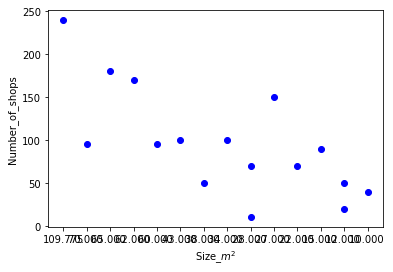

In [31]:
###lets plot mall size vs shop inside mall amount
plt.scatter(feat['Size_$m^2$'], feat.Number_of_shops,  color='blue')
plt.xlabel('Size_$m^2$')
plt.ylabel('Number_of_shops')
plt.show()

In [32]:
##train/test data
msk = np.random.rand(len(mrg_data)) < 0.8
train = feat[msk]
test = feat[~msk]
print(test)

   Size_$m^2$  Number_of_shops  Size_$km^2$  Number_of_people  shops
11    22.000                70         3.12             19321     14
15    10.000                40         4.10             36600     13


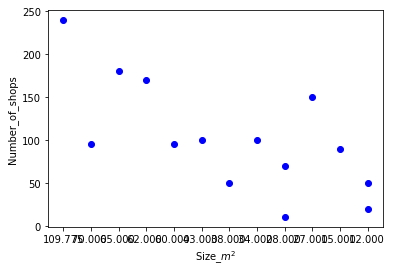

In [33]:
##train data distribution
plt.scatter(train['Size_$m^2$'], train.Number_of_shops,  color='blue')
plt.xlabel('Size_$m^2$')
plt.ylabel('Number_of_shops')
plt.show()

In [34]:
##Pol regression model
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


pr = PolynomialFeatures(degree=2)
x = np.asanyarray(train[['Size_$m^2$','Number_of_people','shops','Size_$km^2$']])
y = np.asanyarray(train[['Number_of_shops']])
x_poly = pr.fit_transform(x)
model = LinearRegression()
model.fit(x_poly,y)

y_poly_pred = model.predict(x_poly)
print(y_poly_pred)
###predicting my new ones 
'''
x_1 = np.asanyarray(mrg_data_1[['size_in_$m^2$','Number_of_people','shops','Size_$km^2$']])
x_poly_1 = pr.fit_transform(x_1)

new_pred = model.predict(x_poly_1)
print(new_pred)
'''
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

'''
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()
'''
'''
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['Size_$m^2$','Number_of_people','shops','Size_$km^2$']])
y = np.asanyarray(train[['Number_of_shops']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)
'''

[[239.99999999]
 [ 95.00000027]
 [180.00000039]
 [170.00000007]
 [ 95.00000051]
 [ 99.9999992 ]
 [ 49.99999994]
 [100.00000046]
 [  9.99999918]
 [ 69.99999977]
 [150.00000047]
 [ 89.99999917]
 [ 50.00000033]
 [ 20.00000022]]
4.725187106471419e-07
0.9999999999999999


"\nregr = linear_model.LinearRegression()\nx = np.asanyarray(train[['Size_$m^2$','Number_of_people','shops','Size_$km^2$']])\ny = np.asanyarray(train[['Number_of_shops']])\nregr.fit (x, y)\n# The coefficients\nprint ('Coefficients: ', regr.coef_)\n"

In [35]:
'''
##prediction
regr = linear_model.LinearRegression()
y_hat= regr.predict(test[['Size_$m^2$','Number_of_people','shops','Size_$km^2$']])
x = np.asanyarray(test[['Size_$m^2$','Number_of_people','shops','Size_$km^2$']])
y = np.asanyarray(test[['Number_of_shops']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

'''

'\n##prediction\nregr = linear_model.LinearRegression()\ny_hat= regr.predict(test[[\'Size_$m^2$\',\'Number_of_people\',\'shops\',\'Size_$km^2$\']])\nx = np.asanyarray(test[[\'Size_$m^2$\',\'Number_of_people\',\'shops\',\'Size_$km^2$\']])\ny = np.asanyarray(test[[\'Number_of_shops\']])\nprint("Residual sum of squares: %.2f"\n      % np.mean((y_hat - y) ** 2))\n\n# Explained variance score: 1 is perfect prediction\nprint(\'Variance score: %.2f\' % regr.score(x, y))\n\n'

In [36]:
###as we see our model is not accurate 
####  so the least we can do now , is to take averages of the shops amount in malls and assgin to current places 
average = mall['Number_of_shops'].mean()
int(average)

95

### So we can  build  a shopping mall  in Justiniskes or Karoliniskes with around 100+ shops inside.